# Task 1: Earthquake Damage Prediction -- Exploration


The dataset is available on [drivendata.org](https://www.drivendata.org/competitions/57/nepal-earthquake/).
Please download it and place it in a folder named `data/` within the same parent directory as this notebook.

We start by loading the data and conducting some sanity checks:

In [1]:
import pandas as pd

train_values = pd.read_csv('data/train_values.csv')
test_values = pd.read_csv('data/test_values.csv')
train_labels = pd.read_csv('data/train_labels.csv')

assert train_values.shape[0] == train_labels.shape[0]
assert (train_values['building_id'] == train_labels['building_id']).all()
assert train_values.shape[1] == test_values.shape[1]

Let's have a look at the number of rows and columns:

In [2]:
print('Train values:', train_values.shape)
print('Test values:', test_values.shape)
print('Train labels:', train_labels.shape)

Train values: (260601, 39)
Test values: (86868, 39)
Train labels: (260601, 2)


Most of the features are binary:

In [3]:
train_values.nunique()

building_id                               260601
geo_level_1_id                                31
geo_level_2_id                              1414
geo_level_3_id                             11595
count_floors_pre_eq                            9
age                                           42
area_percentage                               84
height_percentage                             27
land_surface_condition                         3
foundation_type                                5
roof_type                                      3
ground_floor_type                              5
other_floor_type                               4
position                                       4
plan_configuration                            10
has_superstructure_adobe_mud                   2
has_superstructure_mud_mortar_stone            2
has_superstructure_stone_flag                  2
has_superstructure_cement_mortar_stone         2
has_superstructure_mud_mortar_brick            2
has_superstructure_c

According to the task description, the data should "often" have missing values, but at least they are not obvious to detect for `pandas`:

In [4]:
train_values.isna().sum().sum()

0

The building IDs uniquely identify the rows of the dataset:

In [5]:
print(train_values['building_id'].nunique() == len(train_values))
print(test_values['building_id'].nunique() == len(test_values))

True
True


The geo-level IDs form a hierarchical partitioning of instances, i.e., each level-2 ID only appears together with one particular level-1 ID, and the same goes for level 3 and level 2:

In [6]:
print((train_values.groupby('geo_level_2_id')['geo_level_1_id'].nunique() == 1).all())
print((train_values.groupby('geo_level_3_id')['geo_level_2_id'].nunique() == 1).all())

True
True


The numerical features show outliers or at least imbalanced distributions:

In [7]:
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
train_values[numerical_features].describe().round(2)

,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
count,260601.00,260601.00,260601.00,260601.00,260601.00
mean,2.13,26.54,8.02,5.43,0.98
std,0.73,73.57,4.39,1.92,0.42
min,1.00,0.00,1.00,2.00,0.00
25%,2.00,10.00,5.00,4.00,1.00
50%,2.00,15.00,7.00,5.00,1.00
75%,2.00,30.00,9.00,6.00,1.00
max,9.00,995.00,100.00,32.00,9.00


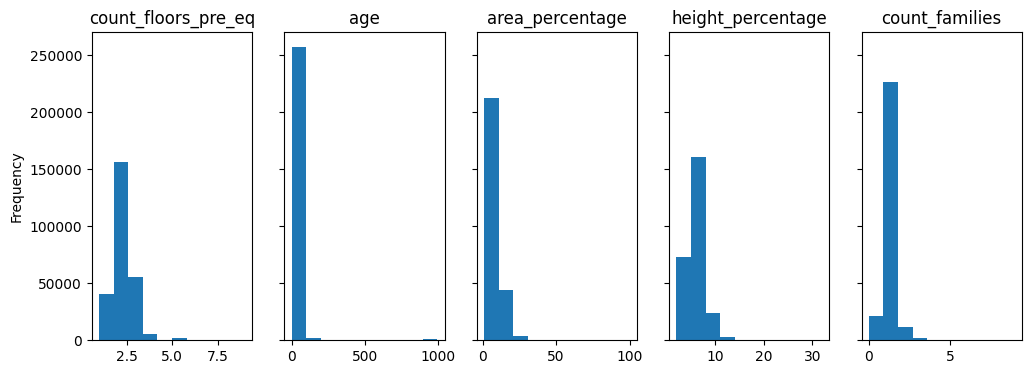

In [8]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(nrows=1, ncols=len(numerical_features), sharey='all', figsize=(12,4))
for i, feature in enumerate(numerical_features):
    train_values[feature].plot.hist(ax=axs[i], title=feature, bins=10)
plt.show()

The categorical features also show imbalanced distributions -- apart from the geo-level IDs, which have many distinct values, the most frequent value of each feature occurs in significantly more than 50% of the instances, for some of the binary features even close to 100% (see column `max`):

In [9]:
categorical_features = [x for x in train_values.columns
                        if (x not in numerical_features) and (x != 'building_id')]
feature_counts = pd.concat([train_values[x].value_counts(normalize=True).describe().rename(x)
                            for x in categorical_features], axis='columns').transpose()
feature_counts.round(2)

,count,mean,std,min,25%,50%,75%,max
geo_level_1_id,31.0,0.03,0.03,0.00,0.01,0.02,0.06,0.09
geo_level_2_id,1414.0,0.00,0.00,0.00,0.00,0.00,0.00,0.02
geo_level_3_id,11595.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
land_surface_condition,3.0,0.33,0.43,0.03,0.08,0.14,0.48,0.83
foundation_type,5.0,0.20,0.36,0.01,0.04,0.05,0.06,0.84
roof_type,3.0,0.33,0.33,0.06,0.15,0.24,0.47,0.70
ground_floor_type,5.0,0.20,0.34,0.00,0.00,0.09,0.10,0.80
other_floor_type,4.0,0.25,0.26,0.05,0.13,0.16,0.28,0.63
position,4.0,0.25,0.36,0.01,0.04,0.11,0.32,0.78
plan_configuration,10.0,0.10,0.30,0.00,0.00,0.00,0.01,0.96


The binary features with the same prefix do not represent a one-hot encoding, since more than one of these columns might be set at the same time:

In [10]:
train_values[[x for x in train_values.columns if 'has_superstructure' in x]].sum(axis='columns').value_counts()

1    176016
2     57838
3     20210
4      4925
5      1259
6       314
7        35
8         4
Name: count, dtype: int64

In [11]:
train_values[[x for x in train_values.columns if 'has_secondary_use' in x]].sum(axis='columns').value_counts()

0    231445
2     28599
3       557
Name: count, dtype: int64

Finally, the prediction target is imbalanced as well:

In [12]:
train_labels['damage_grade'].value_counts(normalize=True).map('{:.2%}'.format)

damage_grade
2    56.89%
3    33.47%
1     9.64%
Name: proportion, dtype: object

The competition is scored with the micro-averaged F1 score.
Let's get a feeling how a simple majority-voting baseline performs:

In [13]:
import sklearn.dummy
import sklearn.metrics

model = sklearn.dummy.DummyClassifier(strategy='most_frequent')
model.fit(X=train_values, y=train_labels['damage_grade'])
prediction = model.predict(X=train_values)
score = sklearn.metrics.f1_score(y_true=train_labels['damage_grade'], y_pred=prediction, average='micro')
print('Micro-averaged F1 score:', round(score, 4))

Micro-averaged F1 score: 0.5689


Definitely higher than zero.
Well, since you hit true positives for the largest class, you get above-zero precision and even maximal recall for that class.
In fact, for single-label prediction, the micro-averaged F1 score (as well as its components, micro-averaged precision and recall) corresponds to plain accuracy [by definition](https://stephenallwright.com/micro-vs-macro-f1-score/).
However, such an equal weighting of all instances (rather than, e.g., equally weighting classes) should be avoided in imbalanced scenarios, since the largest class then mostly influences the scoring.